# Проект: вариант 2
## Задание 1. A/B–тестирование

1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.


1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

* groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
* groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
* checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.


1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

1. На какие метрики Вы смотрите в ходе анализа и почему?
2. Имеются ли различия в показателях и с чем они могут быть связаны?
3. Являются ли эти различия статистически значимыми?
4. Стоит ли запускать новую механику на всех пользователей?

In [1]:
# Импортируем необходимые библиотеки.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [2]:
# Сразу объединим две таблицы: изначальную и ту, которую прислали через два дня.

groups = pd.concat([pd.read_csv('Проект_2_groups.csv', sep=';'),
                    pd.read_csv('Проект_2_group_add.csv')])

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
# Размерность таблицы.

groups.shape

(74576, 2)

In [5]:
# Типы данных в порядке.

groups.dtypes

id      int64
grp    object
dtype: object

In [6]:
# Пропущенных значений нет.

groups.isna().sum()

id     0
grp    0
dtype: int64

In [7]:
# Дубликаты ID не встречаются.

groups.shape[0] == groups.id.nunique()

True

In [8]:
# Сколько человек в каждой группе?

groups.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

In [9]:
# Таблица с пользователями, которые зашли на платформу в дни проведения эксперимента.

active_users = pd.read_csv('Проект_2_active_studs.csv')

In [10]:
active_users.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [11]:
active_users.dtypes

student_id    int64
dtype: object

In [12]:
active_users = active_users.rename(columns={'student_id': 'id'})

In [13]:
# Посмотрим, к какой группе принадлежат пользователи, зашедшие на платформу в дни проведения эксперимента.

active_users_groups = active_users.merge(groups, how='left', on='id')

In [14]:
active_users_groups.head()

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


In [15]:
# Информация о платежах пользователей в дни проведения эксперимента.

checks = pd.read_csv('Проект_2_checks.csv', sep=';')

In [16]:
checks = checks.rename(columns={'student_id': 'id'})

In [17]:
# Можно заметить, что в дни эксперимента нет пользователей, которые совершили покупку более одного раза.

checks.shape[0] == checks.id.nunique()

True

In [18]:
# Объединим информацию о платежах с группой, к которой принадлежат пользователи.

active_checks = active_users_groups.merge(checks, how='left', on='id')

In [19]:
active_checks.head()

,id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN


In [20]:
# Для начала посчитаем конверсию в покупку у обеих групп.
# Мне кажется, что это важный показатель, т.к. он показывает, "проседает" ли какая-то группа в покупках или нет.
# Если, к примеру, наш ARPPU вырастет, а конверсия сильно просядет, то грош цена нашему ARRPU.
# Потому что хоть и средний чек на платящего пользователя и вырастет, но платящих людей в принципе станет меньше.
# Поэтому важно наряду с ARPPU следить и за конверсией в покупку, чтобы держать на контроле эту ситуацию.

conversion_df = active_checks.copy()
conversion_df.rev = conversion_df.rev.fillna(0)
conversion_df.loc[conversion_df.rev > 0, 'rev'] = 1

# 1 - сделал покупку, 0 - нет.

In [21]:
conversion_df.head()

,id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


In [22]:
# Конверсия покупку у группы B немного ниже, чем у группы А. Критично ли это - решает компания.

conversion_df \
        .groupby('grp') \
        .agg({'rev': 'mean'}) \
        .mul(100) \
        .rename(columns={'rev': 'CR_%'})

# Но стоит посмотреть, статистически значимо ли различается конверсия в двух группах. Используем для этого хи-квадрат.
# Нулевая гипотеза Н0: наши конверсии в двух группах статистически значимо не различаются.
# Альтернативная гиоптеза Н1: конверсии в двух группах статистически значимо различаются.
# Возьмём за порог значимости значение 0.05. Если хи-квадрат выдаст меньше, мы можем принять Н1, иначе - оставляем Н0.

,CR_%
grp,
A,5.071521
B,4.615611


In [23]:
# Строим 2х2 таблицу сопряжённости для хи-квадрата.

a = conversion_df.query("grp == 'A'")  # группа А.
b = conversion_df.query("grp == 'B'")  # группа B.

In [24]:
a_converted = a.rev.sum()  # кол-во сконвертировавшихся из группы А.
a_not_converted = a.rev.size - a_converted  # кол-во несконвертировавшихся из группы А.

b_converted = b.rev.sum()  # кол-во сконвертировавшихся из группы В.
b_not_converted = b.rev.size - b_converted  # кол-во несконвертировавшихся из группы В.

In [25]:
# Строим массив numpy из наших данных для использования в chi2_contingency.

T = np.array([[a_converted, a_not_converted], [b_converted, b_not_converted]])
T

array([[  78., 1460.],
       [ 314., 6489.]])

In [26]:
# P - уровень значимости равен 0,445, что намного выше 0,05. Это означает, что мы оставляем нулевую гипотезу.
# Делаем вывод: наши конверсии статистически значимо не различаются.

stats.chi2_contingency(T, correction=False)[1]

0.44547028437158964

In [27]:
# Взглянем на средний чек платящего пользователя (ARPPU).
# Предлагаю использовать именно ARPPU, а не ARPU, т.к. конверсия в двух группах практически не различается.
# Кроме того, ARPPU сразу позволяет сконцентрироваться на наших клиентах.
# Т.е. сразу "точечно" следить за их метриками.

active_checks \
        .groupby('grp') \
        .agg({'rev': 'mean'}) \
        .rename(columns={'rev': 'ARPPU'})

# Видим разницу в среднем чеке. Статистически значимо ли различие?

,ARPPU
grp,
A,933.589744
B,1257.878992


In [28]:
# Выделим пользователей из групп А и B.

users_A = active_checks.query("grp == 'A' and rev > 0")
users_B = active_checks.query("grp == 'B' and rev > 0")

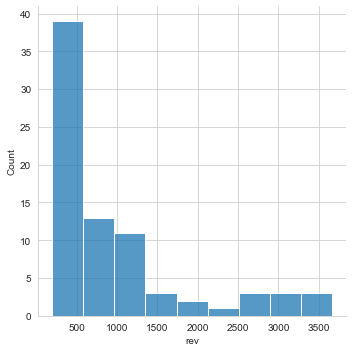

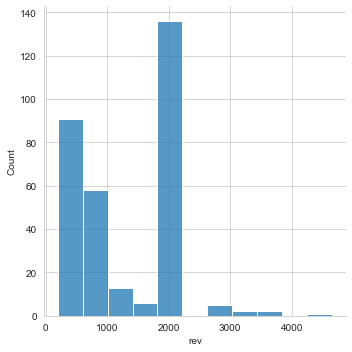

In [29]:
# Распределение платежей пользователей, которые зашли на платформу в дни проведения эксперимента.

sns.displot(users_A.rev, kde=False)
sns.displot(users_B.rev, kde=False)


# Невооружённым глазом видно, что большинство пользователей из целевой группы сделали покупку в районе 2000, скажем, рублей.
# В то же время пользователи из группы А не так сильно раскошелились. Большинство тратило в районе 500 рублей.
# Однако это всё лишь визуально показывает некоторое различие. Что, если копнуть глубже?
# В данном случае я считаю нецелесообразным использовать bootstrap, поскольку уже на этапе визуализации видно, какой сегмент пользователей "подрос" в платежах, т.е. где ИМЕННО разница.
# Поэтому я предлагаю использовать классические критерии. Попробуем t-тест.

In [30]:
# Для начала проверим, равны ли дисперсии в наших группах. Используем для этого тест Левена.
# За порог значимости принимаю значение 0.05.
# Нулевая гипотеза Н0: дисперсии в группах статистически не различаются.
# Альтернативная гипотеза Н1: дисперсии в наших группах статистически различаются.
# Требование гомогенности дисперсий выполняется, т.к. p - уровень значимости > 0.05.
# Оставляем Н0 о равенстве дисперсий.

stats.levene(users_A.rev, users_B.rev)

LeveneResult(statistic=3.0756816999816055, pvalue=0.08025675761347022)

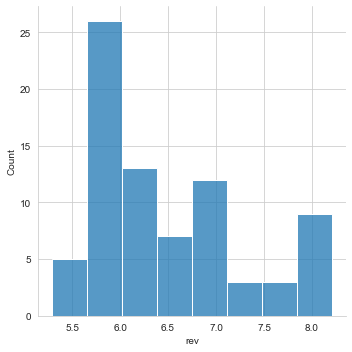

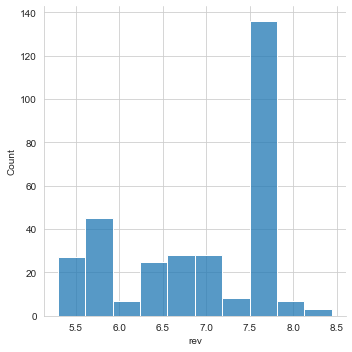

In [31]:
# Очевидно, что наши распределения далеки от нормальных. Логарифмирование не помогло привести их к нормальному.
# Конечно, t-тест мы могли бы использовать и на таких распределениях, но я бы не рисковал, а лишь бы ради любопытства взял на заметку его результаты.

sns.displot(np.log(users_A.rev), kde=False)
sns.displot(np.log(users_B.rev), kde=False)

In [32]:
# Нулевая гипотеза Н0: средние чеки на платящего пользователя в группах статистически значимо НЕ отличаются.
# Альтернативная гипотеза Н1: средние чеки на платящего пользователя в группах статистически значимо отличаются.
# Наши распределения статистически значимо различаются, т.к. p - ур. значимости меньше 0.05.
# Принимаем альтернативную гипотезу.

stats.ttest_ind(users_A.rev, users_B.rev)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

In [33]:
# Посмотрим, что на это скажет непараметрический критерий Манна-Уитни.
# Нулевая гипотеза Н0: средние чеки на платящего пользователя в группах статистически значимо НЕ отличаются.
# Альтернативная гипотеза Н1: средние чеки на платящего пользователя в группах статистически значимо отличаются.
# Наши распределения статистически значимо различаются, т.к. p - ур. значимости меньше 0.05.
# Принимаем альтернативную гипотезу.

stats.mannwhitneyu(users_A.rev, users_B.rev)

# Оба критерия нам говорят о статистически значимых различиях в наших распределениях.

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

Основываясь на результатах стат. тестов, я бы рекомендовал внедрить новую механику оплаты услуг в массы. Единственный момент, на который я бы обратил внимание компании, - это конверсия  (5,07% у контрольной группы против 4,62% у целевой). Однако хи-квадрат показывает, что эти две конверсии статистически значимо не различаются.

Предполагаю, что новая механика оплаты услуг на сайте была призвана увеличить конверсию в покупку, а не средний чек. Вероятно, эксперимент можно считать внезапно удачным. То есть получен положительный результат там, где его, вероятно, не ожидали.
Могу лишь предположить, что новая механика заставляет пользователей тратить больше денег либо путём покупки более дорогих товаров, либо путём покупки большего их количества.

## Задание 2. SQL

2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача

Дана таблица peas.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [34]:
'''
SELECT
    COUNT (*)
FROM
    (
    SELECT
        SUM(correct) AS correct_number
    FROM default.peas
    WHERE timest BETWEEN '2020-03-01' AND '2020-03-31'
    GROUP BY st_id
    )
WHERE correct_number >= 20
'''

"\nSELECT\n    COUNT (*)\nFROM\n    (\n    SELECT\n        SUM(correct) AS correct_number\n    FROM default.peas\n    WHERE timest BETWEEN '2020-03-01' AND '2020-03-31'\n    GROUP BY st_id\n    )\nWHERE correct_number >= 20\n"

2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Даны таблицы: peas (см. выше), studs и final_project_checks.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU
* ARPAU
* CR в покупку
* СR активного пользователя в покупку
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [35]:
# Касательно таблицы studs: т.к. там одному пользователю было присвоено множество меток одновременно (new и old), мне непонятно, как использовать такие данные.
# Я пошёл на условность, и определил группу каждого пользователя в зависимости от длинны массива, который состоит из меток (напр., new, new, new, old, old).
# Если кол-во меток в массиве - чётное число, то пользователь принадлежит группе new, иначе - группе old. Строка 36.

# По ARPAU (Average Revenue per Active User). Под активным пользователем я считал того, у кого есть хотя бы три правильно решённые горошины за всё время. Опять-таки условность.
# Потому что не оговаривается явно, кого считать за активного.

# Общий комментарий: из-за некоторой спутанности в данных и их непрезентабельности (например, в данных всего 30 уникальных пользователей, и конверсия в 100%) возможны ошибки в запросе.
# Бывает сложно представить, что выдаст данный запрос на более полных и массивных данных. Однако, надеюсь, общий смысл я уловил.
# При необходимости готов пояснить логику построения этого запроса.


'''
SELECT
    group,
    ROUND(AVG(money), 2) AS ARPU,
    ROUND(avgIf(money, activity = 'active'), 2) AS ARPAU,
    uniqExactIf(st_id, money > 0) / COUNT(DISTINCT st_id) * 100 AS CR_to_purchase,
    uniqExactIf(st_id, money > 0 AND activity = 'active') / uniqExactIf(st_id, activity = 'active') * 100 AS CR_from_active_to_purchase,
    uniqExactIf(st_id, subject = 'Math' AND money > 0) / uniqExactIf(st_id, subject = 'Math' OR C.subject = 'Math') * 100 AS CR_from_math_to_purchase

FROM
(
    SELECT AB.st_id, AB.money, AB.subject, AB.group, AB.activity, C.subject
    FROM
    (
        SELECT A.st_id, A.money, A.subject, B.group,
            IF(st_id IN (SELECT
                            st_id
                        FROM default.peas
                        GROUP BY st_id
                        HAVING SUM(correct) > 3), 'active', 'sleepy') AS activity
        FROM
            default.final_project_check AS A LEFT JOIN (SELECT
                                                        st_id,
                                                        IF(length(groupArray(test_grp)) % 2 = 0, 'new', 'old') AS group
                                                    FROM default.studs
                                                    GROUP BY st_id) AS B
            ON A.st_id = B.st_id
    ) AS AB FULL OUTER JOIN default.peas AS C
        ON AB.st_id = C.st_id
)

GROUP BY group
'''

"\nSELECT\n    group,\n    ROUND(AVG(money), 2) AS ARPU,\n    ROUND(avgIf(money, activity = 'active'), 2) AS ARPAU,\n    uniqExactIf(st_id, money > 0) / COUNT(DISTINCT st_id) * 100 AS CR_to_purchase,\n    uniqExactIf(st_id, money > 0 AND activity = 'active') / uniqExactIf(st_id, activity = 'active') * 100 AS CR_from_active_to_purchase,\n    uniqExactIf(st_id, subject = 'Math' AND money > 0) / uniqExactIf(st_id, subject = 'Math' OR C.subject = 'Math') * 100 AS CR_from_math_to_purchase\n\nFROM\n(\n    SELECT AB.st_id, AB.money, AB.subject, AB.group, AB.activity, C.subject\n    FROM\n    (\n        SELECT A.st_id, A.money, A.subject, B.group,\n            IF(st_id IN (SELECT\n                            st_id\n                        FROM default.peas\n                        GROUP BY st_id\n                        HAVING SUM(correct) > 3), 'active', 'sleepy') AS activity\n        FROM\n            default.final_project_check AS A LEFT JOIN (SELECT\n                                       

# Задание 3. Python

3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [36]:
# Чтобы симулировать реальное добавление файла, вернём нашу переменную groups к состоянию, когда нам прислали только один файл.

groups = pd.read_csv('Проект_2_groups.csv', sep=';')

In [37]:
groups.shape

(74484, 2)

In [38]:
# Здесь вводим название того файла, который мы хотим добавить.

additional_info = 'Проект_2_group_add.csv'

In [39]:
def show_updated_result(add_file=additional_info,
                        sep=',',
                        base_file=groups,
                        active_users=active_users,
                        checks=checks):
        '''
        Данная функция возвращает два датафрейма: один по конверсии в покупку, второй - по ARPPU.

        :параметр add_file: название .csv файла, в котором содержится доп. информация по пользователям (по умолчанию хранится в переменной additional_info).
        :параметр sep: разделитель в дополнительном .csv файле (по умолчанию ',').
        :параметр base_file: базовый датафрейм с уже имеющимися пользователями (по умолчанию groups).
        :параметр active_users: датафрейм с информацией по пользователям, которые зашли на платформу во время эксперимента (по умолчанию active_users).
        :параметр checks: датафрейм по платежам пользователей, которые зашли на платформу во время эксперимента (по умолчанию checks).
        '''

        file = pd.read_csv(add_file, sep=sep)
        concatenated_file = pd.concat([base_file, file])

        active_users_groups = active_users.merge(concatenated_file, how='left', on='id')
        active_checks = active_users_groups.merge(checks, how='left', on='id')

        conversion_df = active_checks.copy()
        conversion_df.rev = conversion_df.rev.fillna(0)
        conversion_df.loc[conversion_df.rev > 0, 'rev'] = 1

        CR_df = conversion_df \
                .groupby('grp') \
                .agg({'rev': 'mean'}) \
                .mul(100) \
                .rename(columns={'rev': 'CR_%'})

        ARPPU_df = active_checks \
                .groupby('grp') \
                .agg({'rev': 'mean'}) \
                .rename(columns={'rev': 'ARPPU'})

        return {'CR': CR_df, 'ARPPU': ARPPU_df}

In [40]:
show_updated_result()['CR']

,CR_%
grp,
A,5.071521
B,4.615611


In [41]:
show_updated_result()['ARPPU']

,ARPPU
grp,
A,933.589744
B,1257.878992


2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [42]:
def visualize_updated_result(CR_data=show_updated_result()['CR'],
                             ARPPU_data=show_updated_result()['ARPPU']):
        '''
        :параметр CR_data: датафрейм с конверсией (по умолчанию show_updated_result(additional_info)['CR']).
        :параметр ARPPU_data: датафрейм с метрикой ARPPU (по умолчанию show_updated_result(additional_info)['ARPPU']).
        :функция возвращает два барплота этих метрик.
        '''

        fig, axs = plt.subplots(ncols=2)
        fig.tight_layout(pad=5)

        sns.set(rc={'figure.figsize': (10, 5)})
        ax = sns.barplot(data=CR_data.reset_index(),
                         x='grp',
                         y='CR_%',
                         palette='rocket',
                         ax=axs[0])
        ax.set_title('Conversion\n', fontsize=20)
        ax.set_xlabel('\nGroup', fontsize=14)
        ax.set_ylabel('Conversion, %', fontsize=14)

        ay = sns.barplot(data=ARPPU_data.reset_index(),
                         x='grp',
                         y='ARPPU',
                         palette='mako',
                         ax=axs[1])
        ay.set_title('ARPPU\n', fontsize=20)
        ay.set_xlabel('\nGroup', fontsize=14)
        ay.set_ylabel('Roubles', fontsize=14)

        sns.despine()

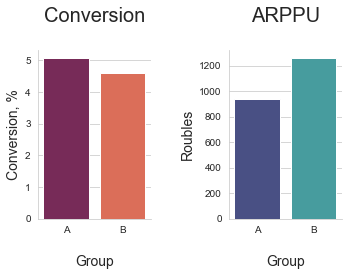

In [43]:
visualize_updated_result()